# <font color="#0000a0">Projet 7 : Effectuez une prédiction de revenus</font>

##  <font color="#0000a0">Objectif projet : proposer une régression linéaire avec 3 variables pour expliquer le revenu de l'enfant y_child ou sa version convertie en log</font>

### **3 variables :**
- le revenu moyen du pays dans lequel habite le prospect : gdp ppp ou ln_gdpppp
- l'indice de Gini calculé sur les revenus des habitants du pays en question : gini
- le revenu des parents : y_parent ou ln_y_parent


## <font color="#0000a0">Dans ce notebook :</font>
1. Attribution d'une classe parent à chaque enfant 
2. ANOVA sur la variable revenus des enfants en fonction du pays
3. Régression linéaire 1 (2 variables explicatives : revenu moyen et indice de gini) avec et sans log
4. Régression linéaire 2 (3 variables explicatives : revenu moyen, indice de gini, classe des parents) avec et sans log 
5. Décomposition de la variance


In [1]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json


Bad key "text.kerning_factor" on line 4 in
/Users/carolinecharrier/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Import du dataframe
df = pd.read_excel('output/df3.xlsx', sheet_name='Sheet1')
del df['Unnamed: 0']
df = df.sort_values(by=['country','quantile'])
df

,country,year_survey,quantile,income,gdpppp,country_name,gini,IGEincome
0,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874
1,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874
2,ALB,2008,3,1010.91600,7297.0,Albanie,30.462429,0.815874
3,ALB,2008,4,1086.90780,7297.0,Albanie,30.462429,0.815874
4,ALB,2008,5,1132.69970,7297.0,Albanie,30.462429,0.815874
...,...,...,...,...,...,...,...,...
11494,ZAF,2008,96,24553.56800,9602.0,Afrique du Sud,66.977850,0.677000
11495,ZAF,2008,97,28858.03100,9602.0,Afrique du Sud,66.977850,0.677000
11496,ZAF,2008,98,35750.29000,9602.0,Afrique du Sud,66.977850,0.677000
11497,ZAF,2008,99,46297.31600,9602.0,Afrique du Sud,66.977850,0.677000


## <font color="#0000a0">1. Attribution d'une classe parent à chaque enfant </font>

### Clonage de 1000 individus


In [3]:
df_try = df.append([df]*999,ignore_index=True)
df_try

,country,year_survey,quantile,income,gdpppp,country_name,gini,IGEincome
0,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874
1,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874
2,ALB,2008,3,1010.91600,7297.0,Albanie,30.462429,0.815874
3,ALB,2008,4,1086.90780,7297.0,Albanie,30.462429,0.815874
4,ALB,2008,5,1132.69970,7297.0,Albanie,30.462429,0.815874
...,...,...,...,...,...,...,...,...
11599995,ZAF,2008,96,24553.56800,9602.0,Afrique du Sud,66.977850,0.677000
11599996,ZAF,2008,97,28858.03100,9602.0,Afrique du Sud,66.977850,0.677000
11599997,ZAF,2008,98,35750.29000,9602.0,Afrique du Sud,66.977850,0.677000
11599998,ZAF,2008,99,46297.31600,9602.0,Afrique du Sud,66.977850,0.677000


In [4]:
# Initialisation classe parent à 1
df_try['c_parent'] = 1
df_try

# Nouveau new_df avec seulement pays et IGE income pour les distributions conditionnelles
df_new = df[['country','IGEincome']].drop_duplicates()
df_new

,country,IGEincome
0,ALB,0.815874
100,ARG,0.500000
200,ARM,0.400000
300,AUT,0.245267
400,AZE,0.500000
...,...,...
10999,VEN,0.500000
11099,VNM,0.480000
5800,XKX,0.400000
11299,YEM,0.500000


### Fonctions nécessaires à la génération des distibutions conditionnelles

In [5]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    plt.gcf().set_size_inches(15, 10)
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

### Calcul des distibutions conditionnelles pour chaque pays 

In [6]:
# Distribution conditionnelles pour les 116 pays, 100 quantiles et 1000 individus
#cd_country = {}
#for idx, row in df_new.iterrows() :
    #pj = row['IGEincome']
    #nb_quantiles = 100       # nombre de quantiles
    #n  = 1000*nb_quantiles   # taille de l'échantillon 1000 * 10 

    #y_child, y_parents = generate_incomes(n, pj) 
    #sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    #cd = conditional_distributions(sample, nb_quantiles) 

    #cd_country[row['country']] = cd.tolist()

### Stockage des distributions conditionnelles dans fichier JSON

In [7]:
#with open("cd_country.json", "w") as file:
    #json.dump(cd_country, file)

### Passage du fichier JSON en dictionnaire

In [8]:
# mettre les distributions conditionnelles dans variable cd
with open('cd_country.json', 'r') as f:
    cd = json.load(f) 
    
type(cd)

dict

### Calcul du nombre de classe parents pour chaque classe enfant 

In [9]:
c_parent = []
for country,value in cd.items():
    for c_enfant in value:
        for idx,col in enumerate(c_enfant):
            n = int(col*1000)
            c_parent += [idx+1] * n       
len(c_parent)

11600000

### Attribution de ces classes parents dans le dataframe

In [10]:
# Imputation des classes parents
df_try = df_try.sort_values(['country','quantile'], ascending = True)
df_try['c_parent'] = c_parent

df_try.loc[df_try['quantile'] == 2]

,country,year_survey,quantile,income,gdpppp,country_name,gini,IGEincome,c_parent
1,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874,1
11601,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874,1
23201,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874,1
34801,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874,1
46401,ALB,2008,2,916.66235,7297.0,Albanie,30.462429,0.815874,1
...,...,...,...,...,...,...,...,...,...
11553501,ZAF,2008,2,138.34155,9602.0,Afrique du Sud,66.977850,0.677000,83
11565101,ZAF,2008,2,138.34155,9602.0,Afrique du Sud,66.977850,0.677000,88
11576701,ZAF,2008,2,138.34155,9602.0,Afrique du Sud,66.977850,0.677000,92
11588301,ZAF,2008,2,138.34155,9602.0,Afrique du Sud,66.977850,0.677000,94


In [11]:
#Creer un dataframe pour filtrer les incomes enfant
qunatile_merged = df_try[['country','quantile','income']].drop_duplicates()
qunatile_merged.rename(columns={'quantile':'c_parent'}, inplace=True)
qunatile_merged

,country,c_parent,income
0,ALB,1,728.89795
1,ALB,2,916.66235
2,ALB,3,1010.91600
3,ALB,4,1086.90780
4,ALB,5,1132.69970
...,...,...,...
11595,ZAF,96,24553.56800
11596,ZAF,97,28858.03100
11597,ZAF,98,35750.29000
11598,ZAF,99,46297.31600


In [12]:
C = df_try.sort_values(['country','c_parent'])
data = pd.merge(C,qunatile_merged, on =['country','c_parent'], how = 'left')
data.rename(columns={'quantile':'c_child','income_x':'y_child','income_y':'y_parent' }, inplace=True)
data

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent
0,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795
1,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795
2,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795
3,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795
4,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795
...,...,...,...,...,...,...,...,...,...,...
11599995,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000
11599996,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000
11599997,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000
11599998,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000


In [13]:
# Enregistrement du fichier
#data.to_csv('data.csv', index=False)

## <font color="#0000a0">2. ANOVA de la variable revenu enfant en fonction du pays</font>


In [14]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as st
from scipy.stats import t, shapiro, ks_2samp

## ANOVA Hypothèses générales

**H0: Tous les pays ont le même revenu**: Le pays n'a pas d'influence sur le revenu enfant moyen, c'est à dire que les moyennes des revenus enfant sont égales.

**H1: Les revenus dépendent du pays**: Le pays a une influence sur le revenu, c'est à dire que les moyennes des revenus enfants sont significativement différentes.

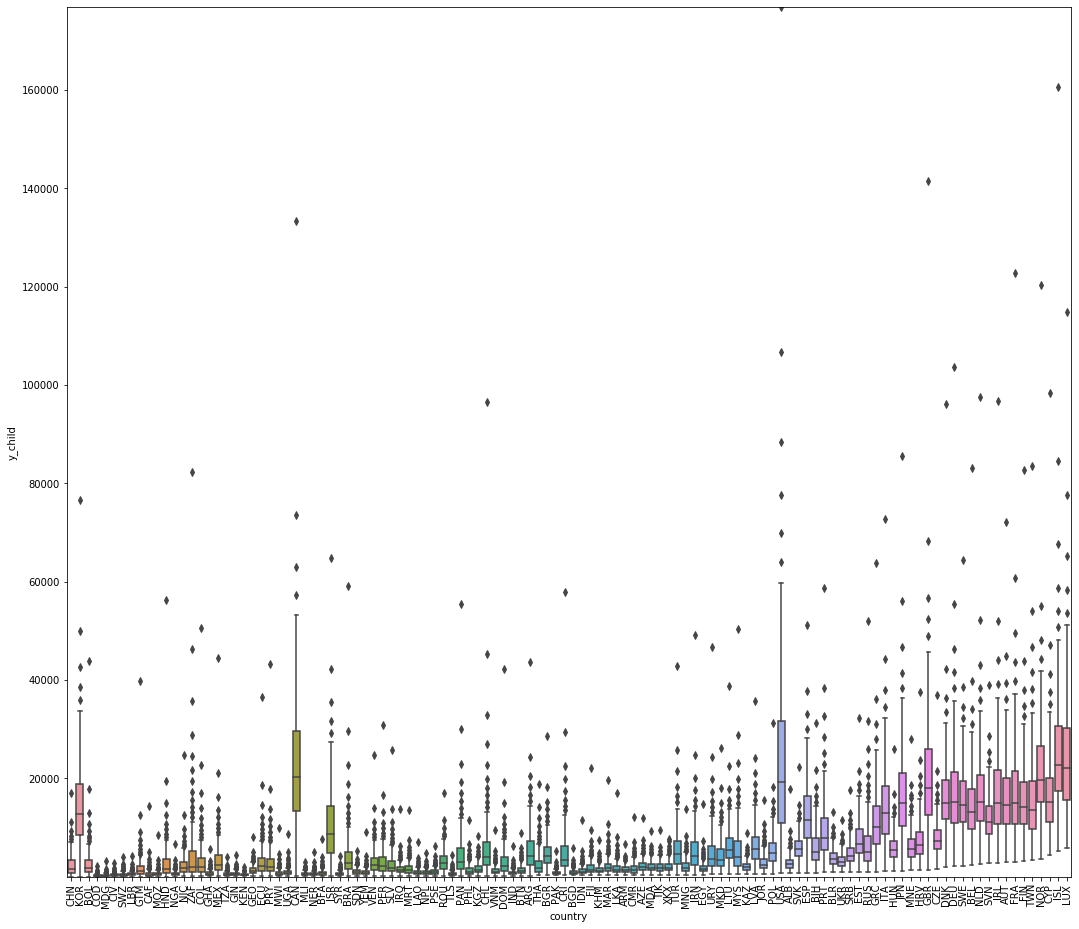

In [15]:
# Distribution des moyennes des revenus enfant par pays (116 boxplots)

data_mean = data[['country','y_child']].drop_duplicates().sort_values(by ='y_child', ascending = True)

# sns boxplots
f, ax = plt.subplots(figsize=(18, 16))
fig = sns.boxplot(x=data_mean['country'], y=data_mean['y_child'], data=data_mean)
fig.axis(ymin=data_mean['y_child'].min(), ymax=data_mean['y_child'].max())
plt.xticks(rotation=90);

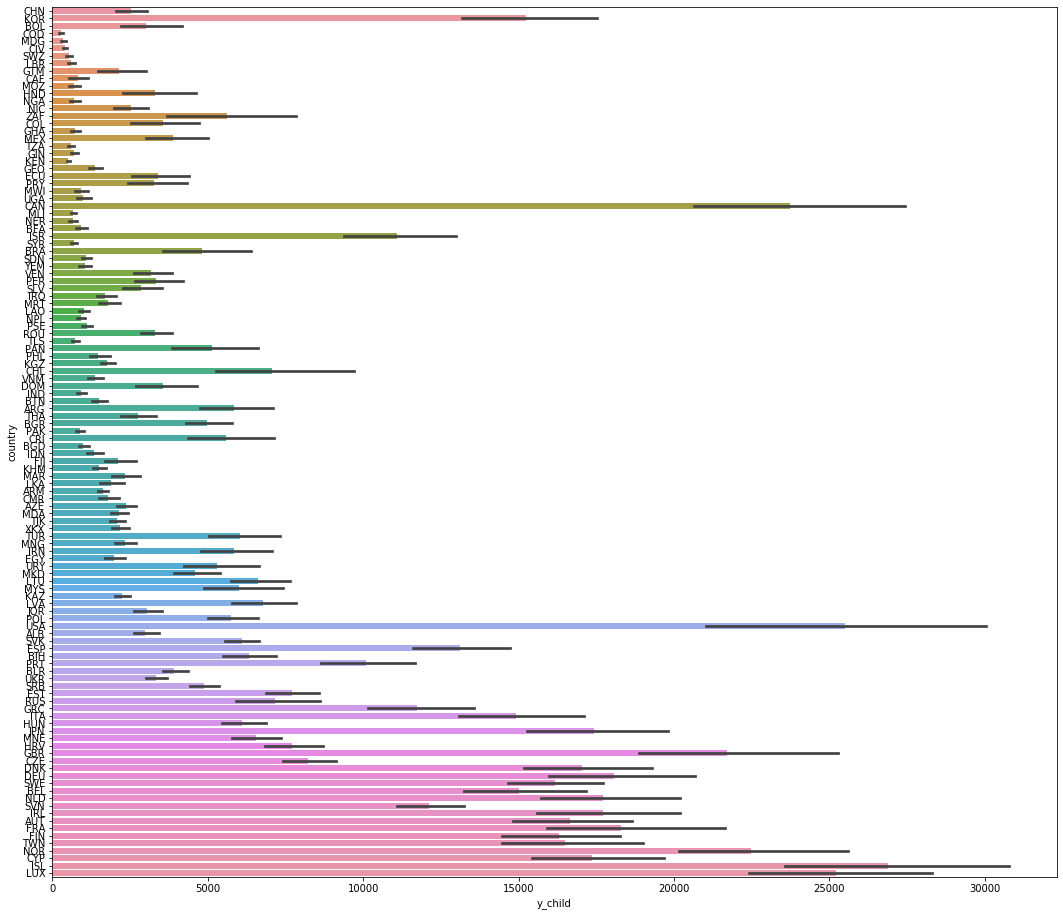

In [16]:
# Visualisation des moyennes revenus enfant pour les 116 pays
f, ax = plt.subplots(figsize=(18, 16))
sns.barplot(x=data_mean['y_child'], y=data_mean['country'], data = data_mean.sort_values(by ='y_child', ascending = True) )

In [17]:
# Classement des moyennes de la plus basse à la plus haute
data_mean.sort_values(by ='y_child', ascending = True)

,country,y_child
1700000,CHN,16.719418
5800000,KOR,17.317732
1100000,BOL,20.584948
2000000,COD,29.364283
6700000,MDG,29.411367
...,...,...
3400999,FRA,122775.164000
1501999,CAN,133454.840000
3501999,GBR,141565.230000
4900998,ISL,160645.270000


In [18]:
moyenne_globale = data_mean.mean()
print("La moyenne globale est de {}".format(moyenne_globale))

La moyenne globale est de y_child    6069.121925
dtype: float64


### <font color="orange">A vue d'oeil, il semblerait que ces moyennes ne soient pas homogènes mais nous allons vérifier cela avec une ANOVA.</font>

## Préparation des données et ANOVA

In [19]:
# Préparation des données à l'ANOVA
anova1 = data.groupby(['country','c_child']).mean()
anova1.reset_index(inplace = True)

In [20]:
# Application de l'ANOVA
anova_pays = smf.ols('y_child ~ country', data=anova1).fit(alpha=0.05)
anova_pays.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_child   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.43
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:42:33   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299    671.390      4.461      0.000    1678.790    4310.870
country[T.ARG]  2853.0548    949.489      3.005      0.003     991.893    4714.216
country[T.ARM] -1366.4471    949.489     -1.439      0.150   -3227.608     494.714
country[T.AUT]  1.364e+04    949.489     14.369      0.000    1.18e+04    1.55e+04
country[T.AZE]  -637.4009    949.489     -0.671      0.502   -2498.562    1223.760
country[T.BEL]  1.203e+04    949.489     12.670      0.000    1.02e+04    1.39e+04
country[T.BFA] -2076.8772    949.489     -2.187      0.029   -3938.039    -215.716
country[T.BGD] -1996.1375    949.489     -2.102      0.036   -3857.299    -134.976
country[T.BGR]  1990.1487    949.489      2.096      0.036     128.987    3851.310
country[T.BIH]  3339.8574    949.489      3.518      0.000    1478.696    5201.019
country[T.BLR]   926.3336    949.489      0.976      0.329    -934.828    2787.495
country[T.BOL]    21.4339    949.489      0.023      0.982   -1839.727    1882.595
country[T.BRA]  1812.6547    949.489      1.909      0.056     -48.507    3673.816
country[T.BTN] -1478.9008    949.489     -1.558      0.119   -3340.062     382.260
country[T.CAF] -2183.5300    949.489     -2.300      0.021   -4044.691    -322.369
country[T.CAN]  2.074e+04    949.489     21.848      0.000    1.89e+04    2.26e+04
country[T.CHL]  4056.7801    949.489      4.273      0.000    2195.619    5917.941
country[T.CHN]  -472.0712    949.489     -0.497      0.619   -2333.232    1389.090
country[T.CIV] -2594.9947    949.489     -2.733      0.006   -4456.156    -733.833
country[T.CMR] -1200.3359    949.489     -1.264      0.206   -3061.497     660.825
country[T.COD] -2718.8139    949.489     -2.863      0.004   -4579.975    -857.653
country[T.COL]   552.1754    949.489      0.582      0.561   -1308.986    2413.337
country[T.CRI]  2585.5567    949.489      2.723      0.006     724.395    4446.718
country[T.CYP]  1.435e+04    949.489     15.114      0.000    1.25e+04    1.62e+04
country[T.CZE]  5240.4635    949.489      5.519      0.000    3379.302    7101.625
country[T.DEU]  1.507e+04    949.489     15.868      0.000    1.32e+04    1.69e+04
country[T.DNK]  1.405e+04    949.489     14.796      0.000    1.22e+04    1.59e+04
country[T.DOM]   563.5722    949.489      0.594      0.553   -1297.589    2424.733
country[T.ECU]   388.9111    949.489      0.410      0.682   -1472.250    2250.072
country[T.EGY] -1025.2525    949.489     -1.080      0.280   -2886.414     835.909
country[T.ESP]  1.012e+04    949.489     10.661      0.000    8261.002     1.2e+04
country[T.EST]  4707.2327    949.489      4.958      0.000    2846.071    6568.394
country[T.FIN]  1.331e+04    949.489     14.020      0.000    1.15e+04    1.52e+04
country[T.FJI]  -896.0990    949.489     -0.944      0.345   -2757.260     965.062
country[T.FR

- La variable pays explique près de 50% de la variance du revenu
- Les autres facteurs non considérés dans le modèle expliquent l'autre moitié de la variance du revenu

- La p-valeur du Test de Fischer est nulle, donc inférieure au seuil de 5%
- **<font color="red">
On rejette donc l'hypothèse H0 et on conclut que le pays a une influence sur le revenu</font>**

## Hypothèses à vérifier pour que l'ANOVA soit valide

1. Les résidus sont normalement distribués : Kolmodorov-Smirnov, Droite de henry Jarque-Bira 
2. Les variances des K populations sont égales entre elles (hypothèse d'homoscédasticité) > Levene
3. Des échantillons aléatoires simple d'effectifs sont prélevés dans les populations indépendamment les unes des autres > Durbin Watson
4. Identifier les valeurs atypiques et influentes 
 ---- Distance de Cook > valeurs influentes
 ---- Valeurs atypiques > 
5. Multi-colinéalrité

En fait, même si les hypothèses du modèle linéaire ne sont pas respectées. La raison à cela, c'est que, comme on dit, le modèle linéaire est robuste, c'est-à-dire que sous réserve qu'il y ait une taille d'échantillon suffisante, les résultats du modèle linéaire restent valables. En termes matheux, on parle de propriétés asymptotiques (i.e. des propriétés valables si n, la taille d'échantillon "tend vers l'infini"...).

## ANOVA : Vérification de l'hypothèse gaussienne sur les résidus

**HO**: les résidus suivent une loi normale 

**H1**: les résidus ne suivent pas une loi normale

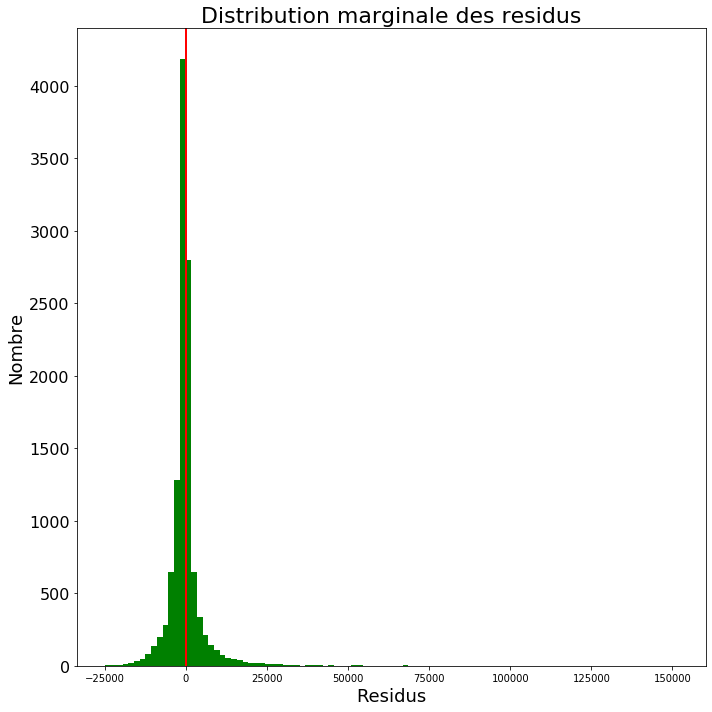

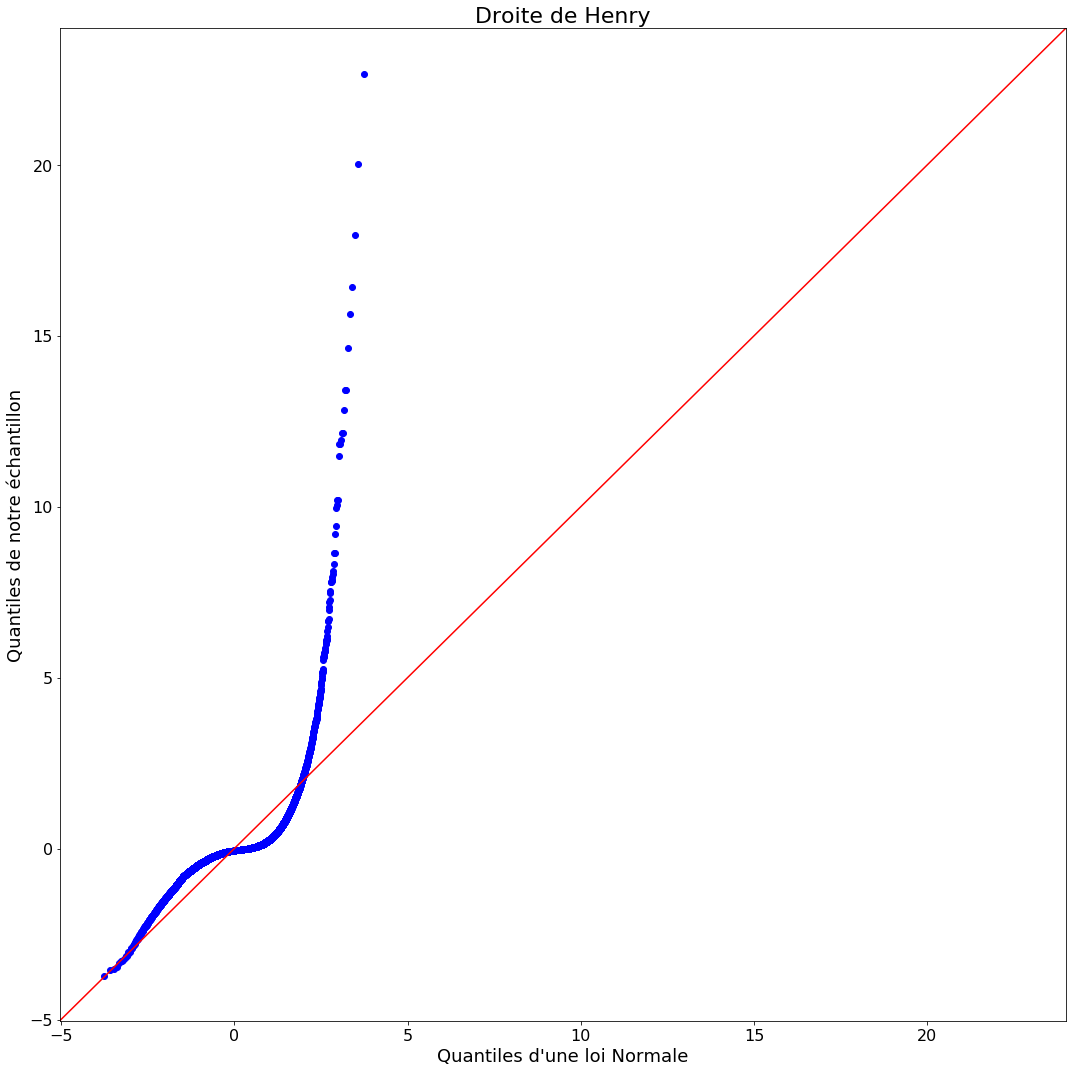

Test de Kolmodorov Smirnov Ks_2sampResult(statistic=0.24344827586206907, pvalue=5.302396834712724e-299)


In [21]:
# Préparation des données
X = anova_pays.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()


# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
print('Test de Kolmodorov Smirnov',ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11600))))

- La p-value est nulle, donc on rejette HO et on accepte H1, les résidus ne suivent pas une loi normale
- **<font color="red">A travers la droite de Henry, la distribution des résidus est davantage visible que sur l'histogramme, les hauts revenus moyens sont peu nombreux et donc très étalés. On rejette HO, les résidus ne suivent pas une loi normale.</font>**

## ANOVA : Homoscédasticité des résidus

**H0:** Homoscédasticité

**H1:** Hétéroscédasticité

In [22]:
print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(anova_pays.resid, anova_pays.model.exog))

Test de Breushch Pagan : (424.61292098761817, 4.725291098356265e-37, 3.7942502768501702, 5.695721173083287e-38)


## Indépendance des résidus

**H0:** Tous les rédisus sont indépendants

**H1:** Au moins 1 des résidus n'est pas dépendant


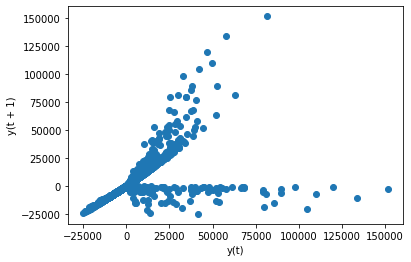

In [23]:
pd.plotting.lag_plot(anova_pays.resid)

In [24]:
print('Test de Durbin Watson :',sm.stats.stattools.durbin_watson(anova_pays.resid, axis=0))

Test de Durbin Watson : 0.672696745021622


- Homoscédasticité : Les p-values sont inférieures au seuil de 5%, rejet de H0, il y a hétéroscédasticité
- Indépéndance : Les valeurs comprises entre 0 et 2 indiquent une auto-corrélation positive</font>

- <font color="red">**Conclusion : Les hypothèses ne sont pas validées pour l'ANOVA, il faut soit se tourner vers une ANOVA non paramétrique ou bien faire une transformation des données pour tendre davatange vers la linéarité**</font>


## <font color="#0000a0">3.1 Première régression linéaire avec 2 variables explicatives : revenu moyen et indice de gini - pas de logarithme</font>

In [25]:
# Ajout de variables logarithmiques au dataframe
data['ln_y_child'] = np.log(data["y_child"])
data['ln_gdpppp'] = np.log(data["gdpppp"])
data['ln_y_parent'] = np.log(data["y_parent"])

data

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent
0,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534
1,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534
2,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534
3,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534
4,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11599995,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444
11599996,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444
11599997,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444
11599998,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444


In [26]:
data_dd = data.drop_duplicates()

## Multicolinéarité entre variables explicatives

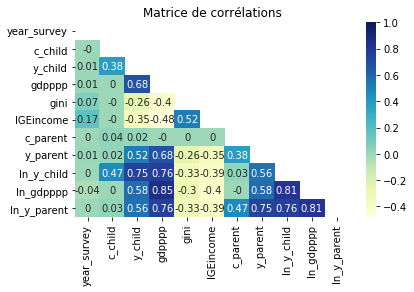

In [27]:
def plot_correlation_matrix(data):
    data_corr = data.corr()
    mask=np.triu(np.ones(data_corr.shape)).astype(np.bool)
    # create heatmap
    sns.heatmap(round(data_corr,2), annot=True, cmap="YlGnBu" ,fmt='g',mask =mask)
    ax.xaxis.set_label_position("bottom")
    plt.tight_layout()
    plt.title('Matrice de corrélations', y=1.1)
    plt.show()
    
plot_correlation_matrix(data_dd)

#### Il ne faut pas que des variables soient corrélées entre elles pour la régression multiple :
- gini et gdp ppp sont corrélés faiblement négativement.

- Notons que gdp ppp est corrélée positivement à y_child : nous attendons une coefficient positif pour gdp ppp dans l'équation
- Notons que gini est corrélé faiblement négativement à y_child : nous attendrons un coefficient négatif pour gini dans l'équation  
- Notons que y_parent est corrélé positive à y_child, ce est logique (cf mission 3)

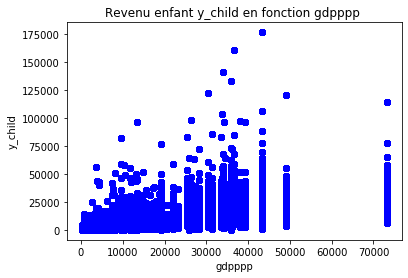

In [28]:
# Revenu de l'enfant en fonction de gdp_ppp
y=data["y_child"]
x1=data["gdpppp"]


plt.scatter(x1, y, color='blue')
plt.title("Revenu enfant y_child en fonction gdpppp ")
plt.xlabel("gdpppp")
plt.ylabel("y_child")
plt.show()

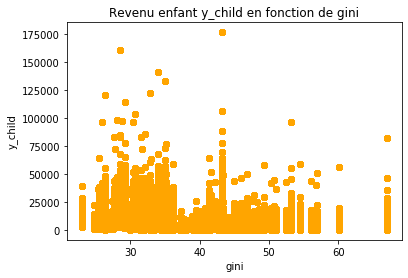

In [29]:
# Revenu de l'enfant en fonction de gini
y=data["y_child"]
x2=data["gini"]

plt.scatter(x2, y, color='orange')
plt.title("Revenu enfant y_child en fonction de gini")
plt.xlabel("gini")
plt.ylabel("y_child")
plt.show()


### Modélisation via Statsmodels

In [30]:
reg = smf.ols('y_child ~ gdpppp + gini', data=data)
reg_multi = reg.fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_child   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                 4.702e+06
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:45:56   Log-Likelihood:            -1.1915e+08
No. Observations:            11600000   AIC:                         2.383e+08
Df Residuals:                11599997   BIC:                         2.383e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -656.7763     10.705    -61.350      0.000    -677.758    -635.794
gdpppp         0.4857      0.000   2843.721      0.000       0.485       0.486
gini          18.0278      0.250     72.049      0.000      17.537      18.518
==============================================================================
Omnibus:                 14341814.886   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3808752193.045
Skew:                           6.545   Prob(JB):                         0.00
Kurtosis:                      90.800   Cond. No.                     9.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Double vérification avec scikit learn
from sklearn import preprocessing

Y=data["y_child"]
X=data[["gdpppp","gini"]]


X_train,X_test,Y_train,Y_test=train_test_split(X,Y)
model=LinearRegression().fit(X_train,Y_train)
print('score:',model.score(X_test,Y_test))
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)

score: 0.4478694466386655
coefficients: [ 0.48578316 18.1000147 ]
intercept: -659.9655088220197


## Reg 1 : Vérification de l'hypothèse gaussienne sur les résidus

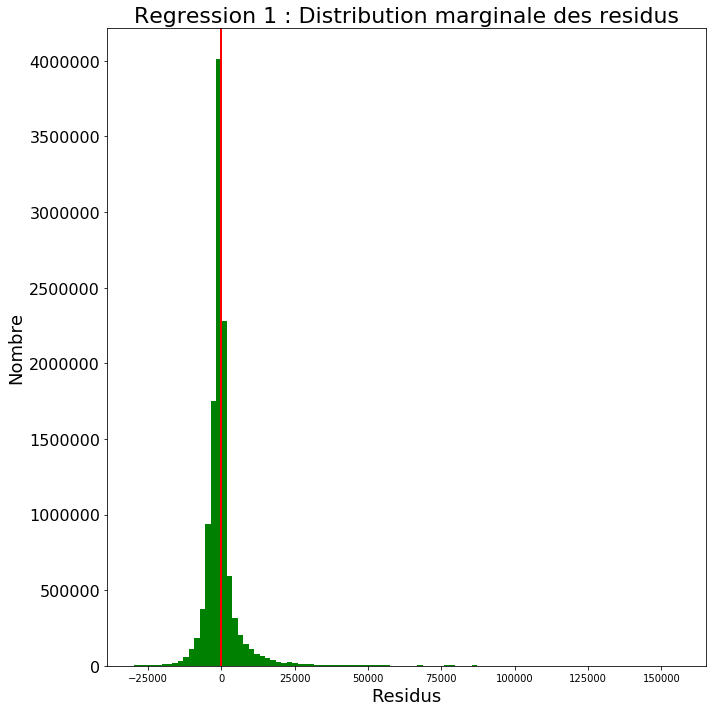

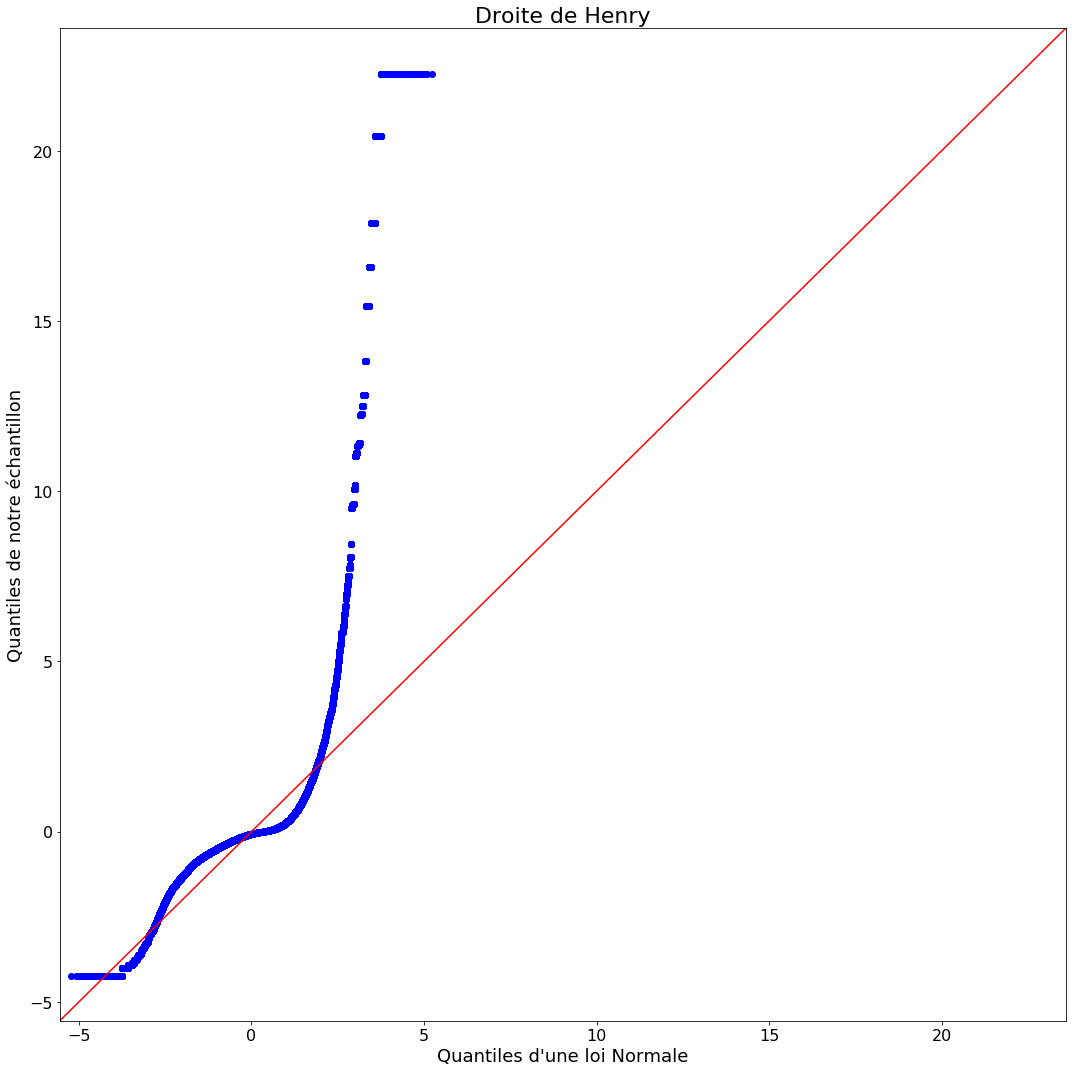

In [32]:
# Préparation des données
X1 = reg_multi.resid
X1bar = np.mean(X1)
X1sprime = np.std(X1)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X1, 100, facecolor='g')
plt.axvline(X1bar, color='r', linewidth=2)

plt.title(f'Regression 1 : Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X1, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()


In [33]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(X1,list(np.random.normal(X1bar, X1sprime, 11600)))

Ks_2sampResult(statistic=0.24267241379310345, pvalue=0.0)

- La p-value est nulle, donc on rejette HO et on accepte H1, les résidus ne suivent pas une loi normale
- **<font color="red">La courbe de Henry permet de mieux se rendre compte que la distribution n'est pas gausienne</font>**



## Reg 1 : Homoscédasticité des résidus

**H0:** Homoscédasticité 

**H1:** Hétéroscédasticité 

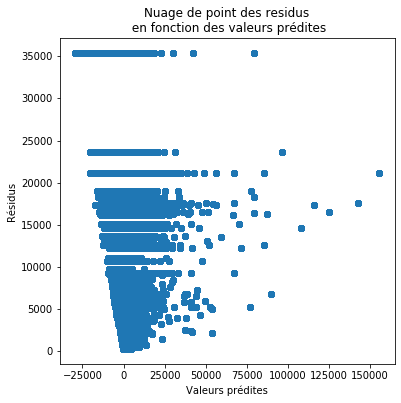

Test de Breushch Pagan : (288820.6891229974, 0.0, 148097.69323270203, 0.0)


In [34]:
plt.figure(figsize=(6,6))
plt.scatter(reg_multi.resid, reg_multi.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

#plt.savefig('graph/homoscedasticity2.png')
plt.show()

print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(reg_multi.resid, reg_multi.model.exog))

## Indépendance des résidus

**H0:** Tous les rédisus sont indépendants

**H1:** Au moins 1 des résidus n'est pas dépendant

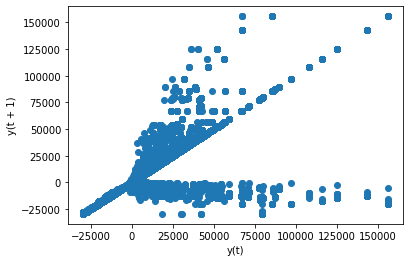

0.06327207171667107


In [35]:
pd.plotting.lag_plot(reg_multi.resid)
plt.show()

print(sm.stats.stattools.durbin_watson(reg_multi.resid, axis=0))

## Valeurs abberantes, distance de Cook sur residus

In [106]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

#Création du dataframe avec tous les resultats d'influences disponibles
#infl = reg_multi.get_influence().summary_frame()
reg_log2.get_influence().cooks_distance[0]

#infl.head()

# Paramètres de l'étude
n = ready_db2.shape[0]
p = 3

# Seuil levier selon Belsey
seuil_levier = 2 * p / n

AttributeError: 'OLS' object has no attribute 'get_influence'

## <font color="#0000a0">4.1 Première régression linéaire avec 2 variables explicatives : revenu moyen et indice de gini - avec logarithme</font>



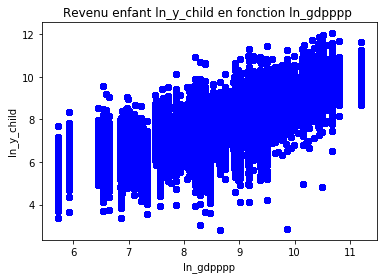

In [37]:
# Revenu log de l'enfant en fonction de ln_gdp_ppp
ylog=data["ln_y_child"]
xlog1=data["ln_gdpppp"]


plt.scatter(xlog1, ylog, color='blue')
plt.title("Revenu enfant ln_y_child en fonction ln_gdpppp ")
plt.xlabel("ln_gdpppp")
plt.ylabel("ln_y_child")
plt.show()

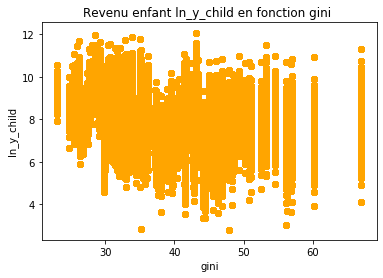

In [38]:
# Revenu log de l'enfant en fonction de gini
ylog=data["ln_y_child"]
xlog2=data["gini"]


plt.scatter(xlog2, ylog, color='orange')
plt.title("Revenu enfant ln_y_child en fonction gini ")
plt.xlabel("gini")
plt.ylabel("ln_y_child")
plt.show()

In [39]:
# Test global avec stat models
reg_log2 = smf.ols('ln_y_child ~ ln_gdpppp + gini', data=data)
reg_multi_log2 = reg_log2.fit()
reg_multi_log2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 1.087e+07
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:53:40   Log-Likelihood:            -1.4080e+07
No. Observations:            11600000   AIC:                         2.816e+07
Df Residuals:                11599997   BIC:                         2.816e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7843      0.002    334.806      0.000       0.780       0.789
ln_gdpppp      0.8658      0.000   4269.376      0.000       0.865       0.866
gini          -0.0149    2.8e-05   -531.250      0.000      -0.015      -0.015
==============================================================================
Omnibus:                   393604.807   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1069810.986
Skew:                          -0.102   Prob(JB):                         0.00
Kurtosis:                       4.474   Cond. No.                         392.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  Reg 1 log : Vérification de l'hypothèse gaussienne sur les résidus

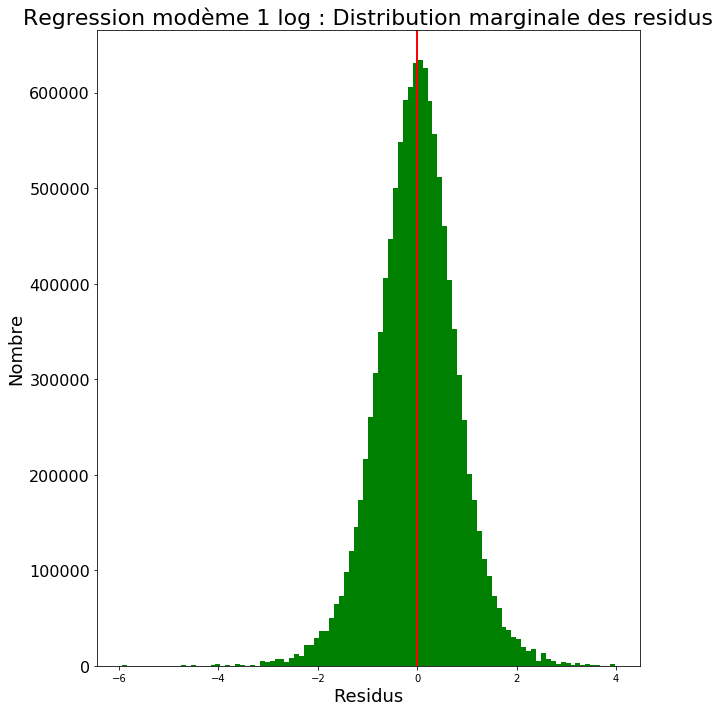

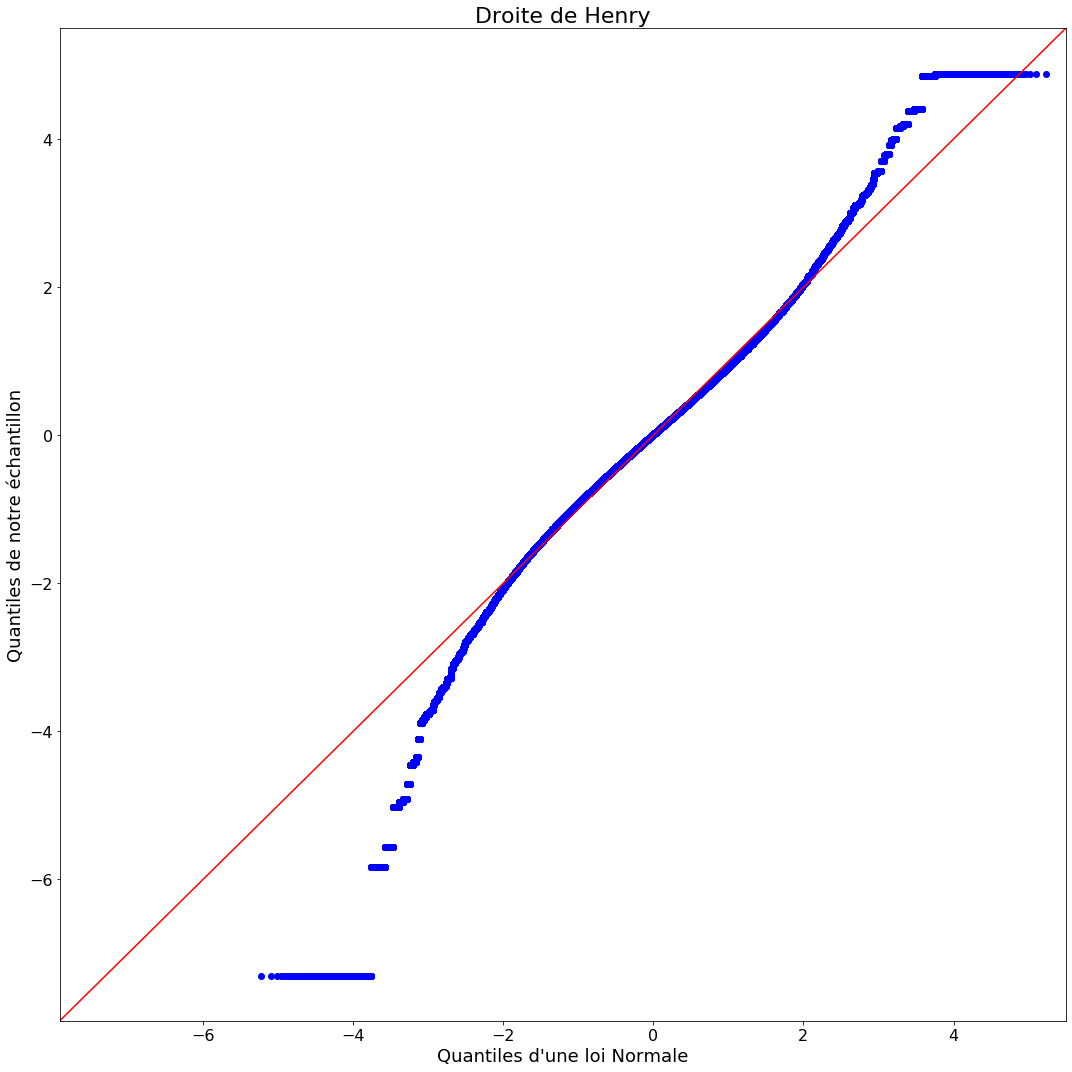

In [40]:
# Préparation des données
X2 = reg_multi_log2.resid
X2bar = np.mean(X2)
X2sprime = np.std(X2)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X2, 100, facecolor='g')
plt.axvline(X2bar, color='r', linewidth=2)

plt.title(f'Regression modème 1 log : Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X2, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()

In [41]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
ks_2samp(X2,list(np.random.normal(X2bar, X2sprime, 11600)))

Ks_2sampResult(statistic=0.024051724137931024, pvalue=3.007782583858826e-06)

- La p-value est nulle, donc on rejette HO et on accepte H1, les résidus ne suivent pas une loi normale
- **<font color="red">Toutefois, la transformation des variables au log a permis de suivre davanatage une distribution gaussiene.</font>**


## Reg 1 log : Homoscédasticité des résidus

**H0:** homoscédasticité 

**H1:** hétéroscédasticité 

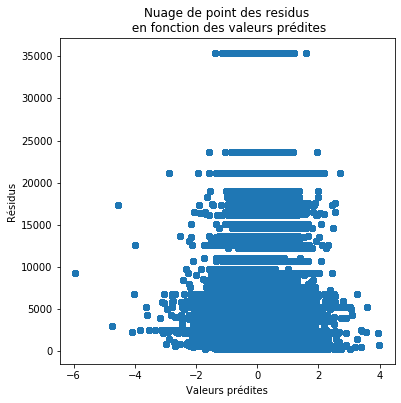

Test de Breushch Pagan : (575912.334850349, 0.0, 302999.2848136681, 0.0)


In [42]:
plt.figure(figsize=(6,6))
plt.scatter(reg_multi_log2.resid, reg_multi.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

#plt.savefig('graph/homoscedasticity2.png')
plt.show()

print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(reg_multi_log2.resid, reg_multi_log2.model.exog))



## Reg 1 log : Indépendance des résidus

**H0:** Tous les rédisus sont indépendants

**H1:** Au moins 1 des résidus n'est pas dépendant

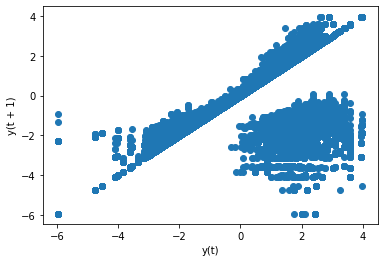

Test de Durbin-Warson: 0.027372257613637967


In [43]:
pd.plotting.lag_plot(reg_multi_log2.resid)
plt.show()

print('Test de Durbin-Warson:',sm.stats.stattools.durbin_watson(reg_multi_log2.resid, axis=0))

In [44]:
# Double vérification avec un modéle avec scikit learn
Y=data["ln_y_child"]
X=data[["ln_gdpppp","gini"]]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y)
model2=LinearRegression().fit(X_train,Y_train)
print('score:',model2.score(X_test,Y_test))
print('coefficients:',model2.coef_)
print('intercept:',model2.intercept_)


score: 0.652258723946493
coefficients: [ 0.86570485 -0.01486073]
intercept: 0.7844358076107323


## <font color="#0000a0">4.2 Deuxième régression linéaire avec 3 variables explicatives : revenu moyen, indice de gini et revenu des parents - sans logarithme</font>


In [45]:
reg3 = smf.ols('y_child ~ gdpppp + gini + y_parent ', data=data)
reg_multi3 = reg3.fit()
reg_multi3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_child   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                 4.058e+06
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:57:45   Log-Likelihood:            -1.1844e+08
No. Observations:            11600000   AIC:                         2.369e+08
Df Residuals:                11599996   BIC:                         2.369e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -432.6232     10.064    -42.986      0.000    -452.349    -412.898
gdpppp         0.3200      0.000   1529.725      0.000       0.320       0.320
gini          11.8751      0.235     50.480      0.000      11.414      12.336
y_parent       0.3413      0.000   1236.654      0.000       0.341       0.342
==============================================================================
Omnibus:                 14227292.777   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4016403055.065
Skew:                           6.416   Prob(JB):                         0.00
Kurtosis:                      93.250   Cond. No.                     1.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Reg 2 : Vérification de l'hypothèse gaussienne sur les résidus

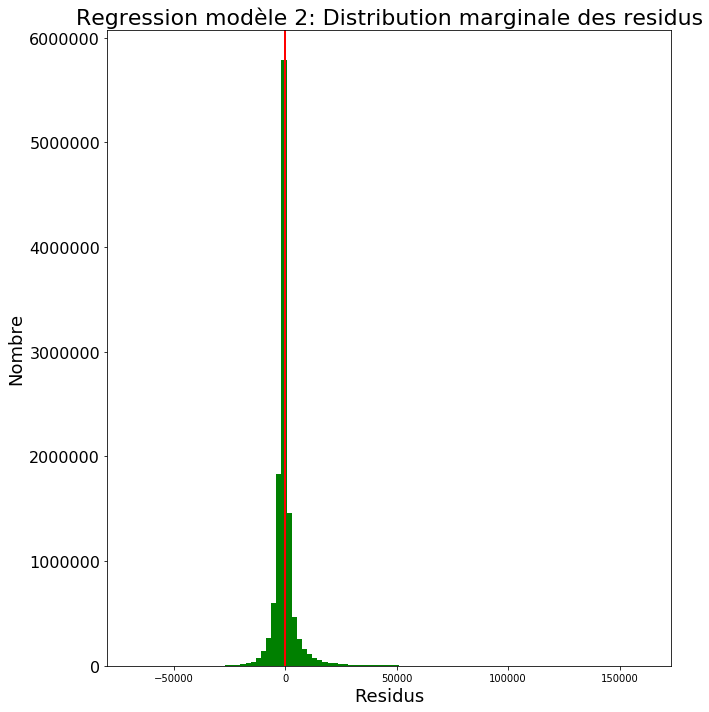

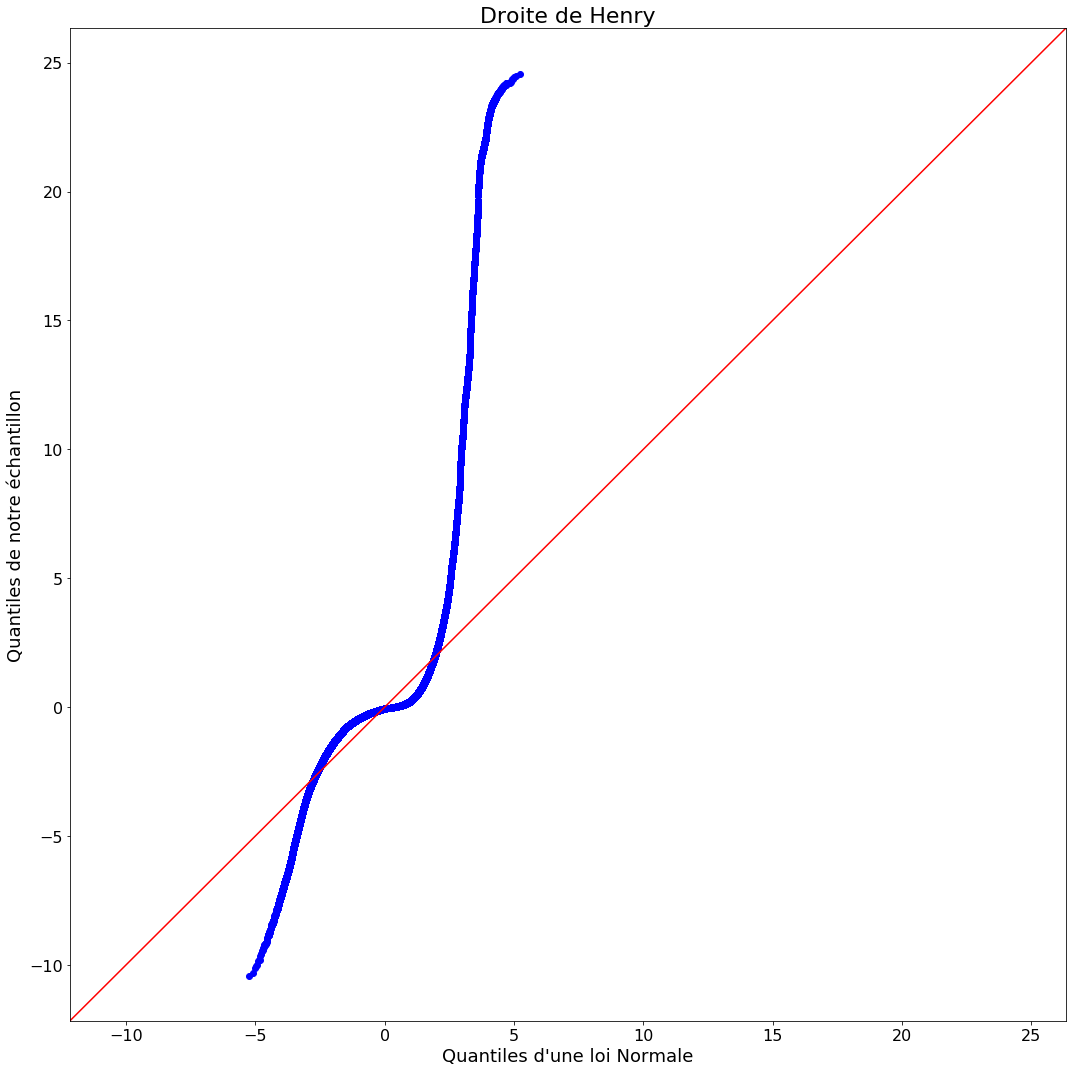

Ks_2sampResult(statistic=0.24446387931034474, pvalue=0.0)


In [46]:
# Préparation des données
X3 = reg_multi3.resid
X3bar = np.mean(X3)
X3sprime = np.std(X3)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X3, 100, facecolor='g')
plt.axvline(X3bar, color='r', linewidth=2)

plt.title(f'Regression modèle 2: Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X3, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()

# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
print(ks_2samp(X3,list(np.random.normal(X3bar, X3sprime, 11600))))

## Reg 2 : Homoscédasticité des résidus

**H0:** homoscédasticité 

**H1:** hétéroscédasticité 

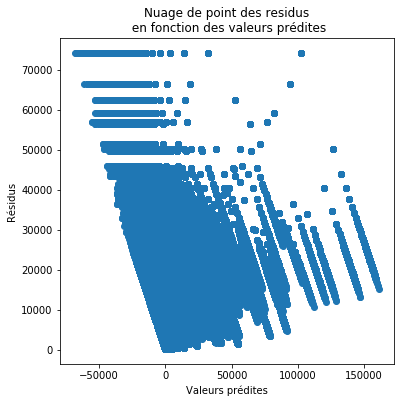

Test de Breushch Pagan : (516315.2057004154, 0.0, 180122.23768592146, 0.0)


In [47]:
# Résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))
plt.scatter(reg_multi3.resid, reg_multi3.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

#plt.savefig('graph/homoscedasticity2.png')
plt.show()

print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(reg_multi3.resid, reg_multi3.model.exog))



## Reg 2 : Indépendance des résidus

**H0:** Tous les rédisus sont indépendants

**H1:** Au moins 1 des résidus n'est pas dépendant

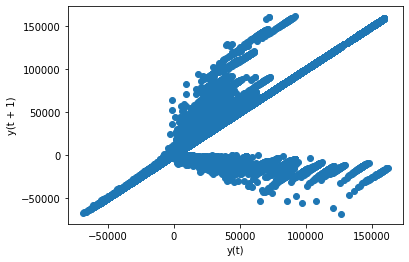

0.07173356195426465
Test de Durbin Watson: None


In [48]:
pd.plotting.lag_plot(reg_multi3.resid)
plt.show()

print('Test de Durbin Watson:',print(sm.stats.stattools.durbin_watson(reg_multi3.resid, axis=0)))

## <font color="#0000a0">4.2 Deuxième régression linéaire avec 3 variables explicatives : revenu moyen, indice de gini et revenu des parents - avec logarithme</font>

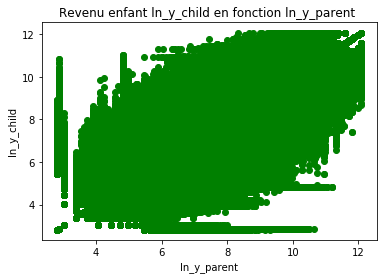

In [107]:
# Revenu log de l'enfant en fonction de gini
ylog=data["ln_y_child"]
xlog2=data["ln_y_parent"]


plt.scatter(xlog2, ylog, color='green')
plt.title("Revenu enfant ln_y_child en fonction ln_y_parent ")
plt.xlabel("ln_y_parent")
plt.ylabel("ln_y_child")
plt.show()

In [49]:
reg4 = smf.ols('ln_y_child ~ ln_gdpppp + gini + ln_y_parent  ', data=data)
reg_multi4 = reg4.fit()
reg_multi4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 1.273e+07
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:03:07   Log-Likelihood:            -1.1754e+07
No. Observations:            11600000   AIC:                         2.351e+07
Df Residuals:                11599996   BIC:                         2.351e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3335      0.002    173.131      0.000       0.330       0.337
ln_gdpppp       0.3681      0.000   1383.426      0.000       0.368       0.369
gini           -0.0063   2.32e-05   -272.741      0.000      -0.006      -0.006
ln_y_parent     0.5748      0.000   2392.532      0.000       0.574       0.575
==============================================================================
Omnibus:                   544588.481   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1966239.692
Skew:                          -0.048   Prob(JB):                         0.00
Kurtosis:                       5.015   Cond. No.                         400.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Reg log 2 : Vérification de l'hypothèse gaussienne sur les résidus

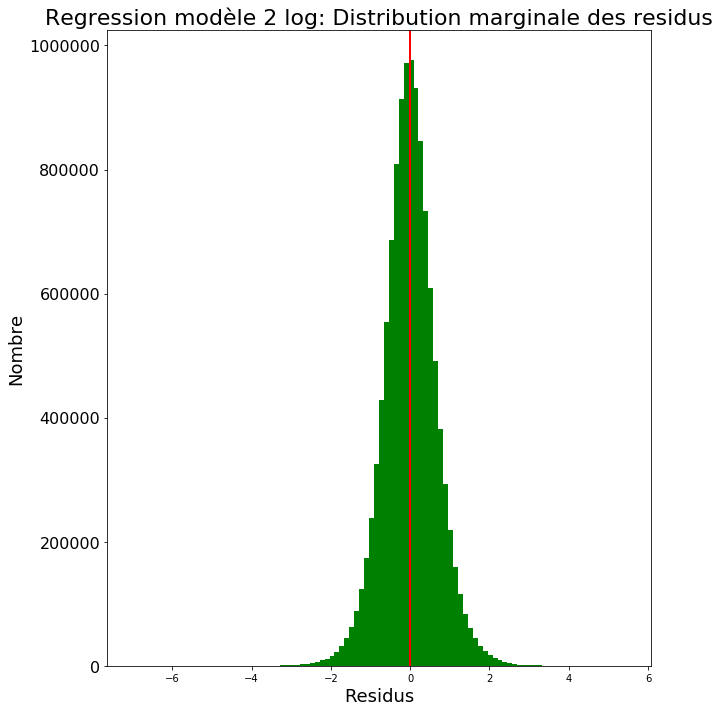

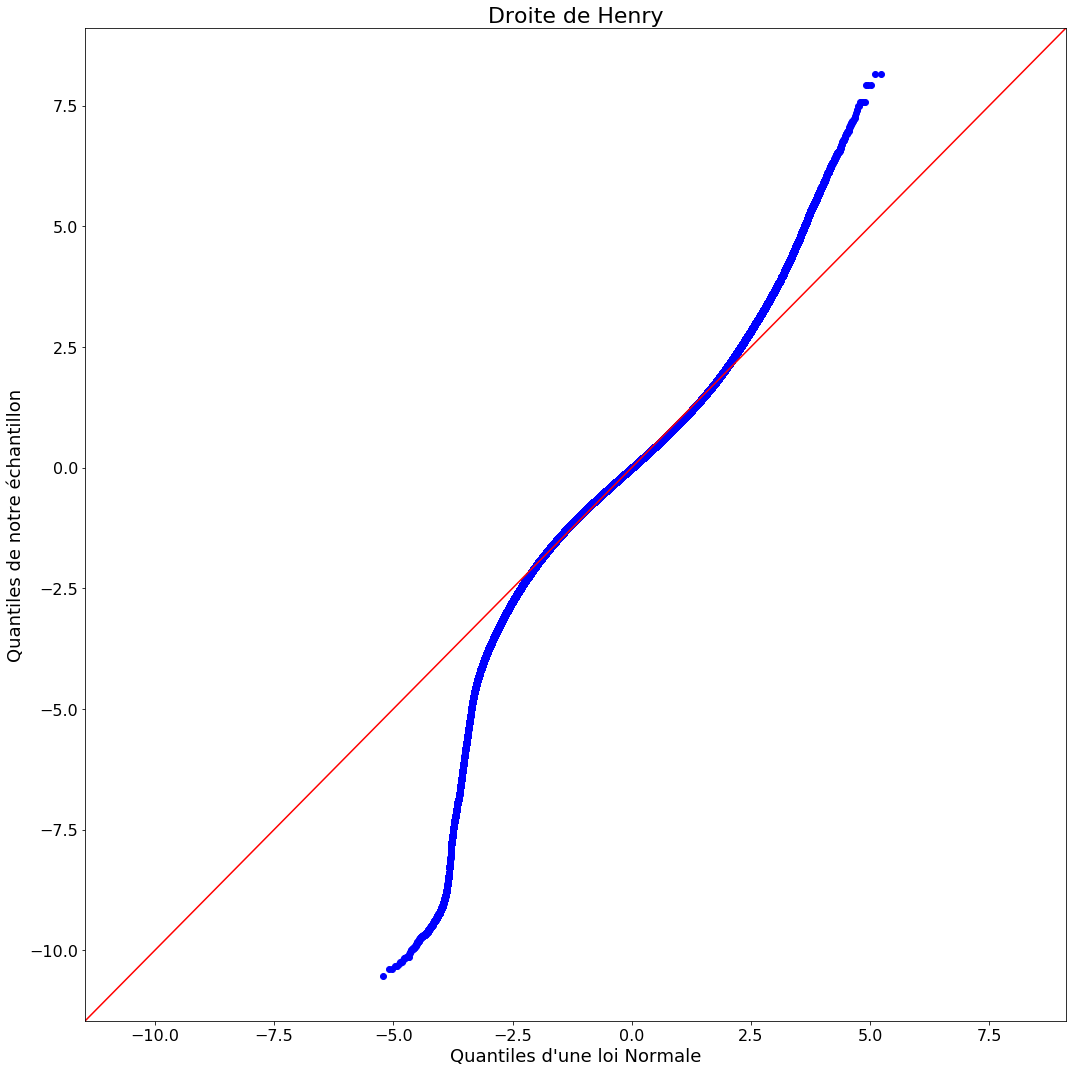

Ks_2sampResult(statistic=0.02390094827586209, pvalue=3.5564896371132108e-06)


In [50]:
# Préparation des données
X4 = reg_multi4.resid
X4bar = np.mean(X4)
X4sprime = np.std(X4)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X4, 100, facecolor='g')
plt.axvline(X4bar, color='r', linewidth=2)

plt.title(f'Regression modèle 2 log: Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X4, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()

# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
print(ks_2samp(X4,list(np.random.normal(X4bar, X4sprime, 11600))))

## Homoscédasticité des résidus

**H0:** homoscédasticité 

**H1:** hétéroscédasticité 

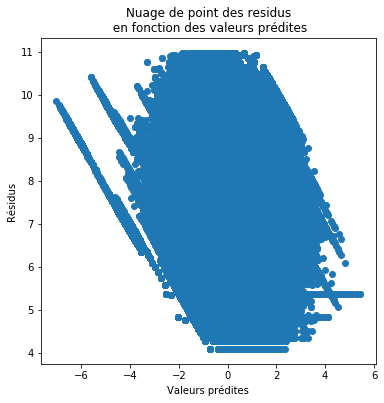

Test de Breushch Pagan : (463263.17774012237, 0.0, 160844.57217281018, 0.0)


In [51]:
# Résidus en fonction des valeurs prédites
plt.figure(figsize=(6,6))
plt.scatter(reg_multi4.resid, reg_multi4.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

#plt.savefig('graph/homoscedasticity2.png')
plt.show()

print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(reg_multi4.resid, reg_multi4.model.exog))


## Indépendance des résidus

**H0:** Tous les rédisus sont indépendants

**H1:** Au moins 1 des résidus n'est pas dépendant

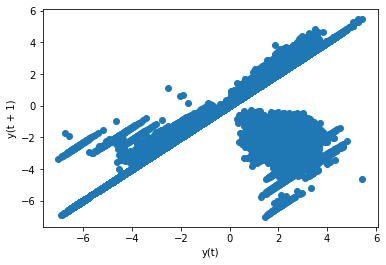

0.07173356195426465
Test de Durbin Watson: None


In [52]:
pd.plotting.lag_plot(reg_multi4.resid)
plt.show()

print('Test de Durbin Watson:',print(sm.stats.stattools.durbin_watson(reg_multi3.resid, axis=0)))

## Détection des valeurs atypiques sur variable explicative

In [118]:
# Paramètres de l'étude
n = data.shape[0]
p = 3

# Seuil levier selon Belsey
seuil_levier = 2 * p / n

# Ajout des termes diagonaux de H
data['levier'] = reg_multi3.get_influence().hat_matrix_diag

data.sort_values(by='levier', ascending=False).head()

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent,levier
11099747,USA,2008,97,77634.82,43261.0,États-Unis,43.179916,0.537666,100,176928.55,11.259771,10.675007,12.083501,0.000044
11099670,USA,2008,96,69926.37,43261.0,États-Unis,43.179916,0.537666,100,176928.55,11.155198,10.675007,12.083501,0.000044
11099657,USA,2008,95,64053.35,43261.0,États-Unis,43.179916,0.537666,100,176928.55,11.067472,10.675007,12.083501,0.000044
11099658,USA,2008,95,64053.35,43261.0,États-Unis,43.179916,0.537666,100,176928.55,11.067472,10.675007,12.083501,0.000044
11099659,USA,2008,95,64053.35,43261.0,États-Unis,43.179916,0.537666,100,176928.55,11.067472,10.675007,12.083501,0.000044


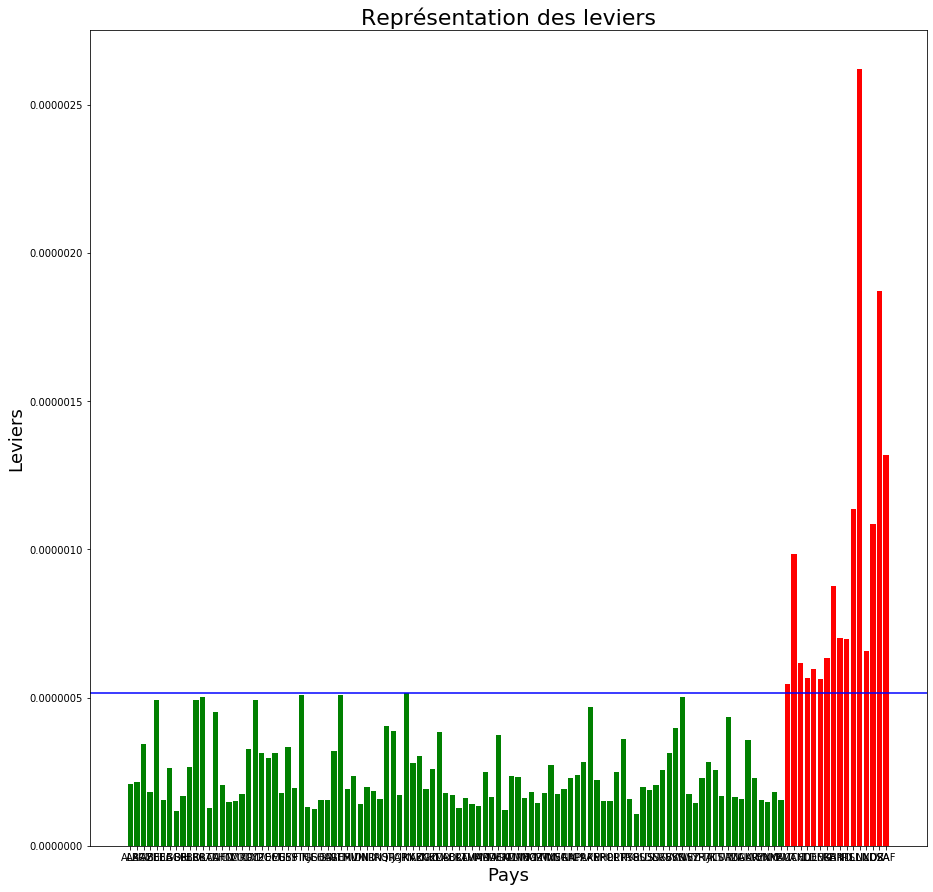

In [121]:
data2 = data.groupby(['country', 'gdpppp', 'gini', 'IGEincome', 'ln_gdpppp']).mean()
data2.reset_index(inplace=True)

# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(data2.loc[data2['levier'] <= seuil_levier]['country'],
        data2.loc[data2['levier'] <= seuil_levier]['levier'], color='g')

# Individus au dessus du seuil
plt.bar(data2.loc[data2['levier'] > seuil_levier]['country'],
        data2.loc[data2['levier'] > seuil_levier]['levier'], color='r')


# Décoration et annotations
plt.title('Représentation des leviers', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.ylabel('Leviers', fontsize=18)
plt.axhline(y=seuil_levier, color='b', linestyle='-')


In [122]:
# Nombre de valeurs atypiques sur les variables explicatives
lev_ln = data.loc[data['levier'] > seuil_levier, :]
len(lev_ln)

1044000

In [123]:
# Pays presentants des valeurs atypiques
data2.loc[data2['levier'] > seuil_levier]

,country,gdpppp,gini,IGEincome,ln_gdpppp,year_survey,c_child,y_child,c_parent,y_parent,ln_y_child,ln_y_parent,levier
3,AUT,36193.0,27.827911,0.245267,10.496621,2008.0,50.5,16637.600204,50.5,16637.600204,9.589967,9.589967,5.472142e-07
15,CAN,35895.0,35.021877,0.269333,10.488353,2008.0,50.5,23739.640518,50.5,23739.640518,9.814498,9.814498,9.862968e-07
16,CHL,13390.0,53.157587,0.570000,9.502263,2009.0,50.5,7051.609966,50.5,7051.609966,8.362420,8.362420,6.180335e-07
21,COL,8185.0,56.927123,1.095440,9.010058,2008.0,50.5,3547.005276,50.5,3547.005275,7.556374,7.556374,5.671321e-07
25,DEU,33758.0,30.646529,0.237904,10.426973,2008.0,50.5,18061.718142,50.5,18061.718142,9.640196,9.640196,5.982318e-07
26,DNK,34130.0,25.987115,0.145146,10.437932,2008.0,50.5,17043.146491,50.5,17043.146491,9.622365,9.622365,5.645190e-07
34,FRA,30357.0,32.909624,0.357105,10.320782,2008.0,50.5,18309.407545,50.5,18309.407545,9.632056,9.632056,6.336325e-07
35,GBR,34048.0,33.938208,0.480978,10.435527,2008.0,50.5,21709.604470,50.5,21709.604470,9.781875,9.781875,8.768715e-07
41,HND,3628.0,60.166676,0.500000,8.196437,2008.0,50.5,3296.268419,50.5,3296.268419,7.380957,7.380957,7.016492e-07
46,IRL,39268.0,30.343974,0.256399,10.578165,2008.0,50.5,17710.735838,50.5,17710.735838,9.627183,9.627183,6.965826e-07


## Résidus studentisés sur variable à expliquer

In [127]:
# Détermination du seuil statistique d'atypicité
seuil_rstudent = t.ppf(1-0.05/2,n-p-1)
seuil_rstudent

1.9599641890462858

In [128]:
# statistique de test par observation
data['rstudent'] = reg_multi3.get_influence().resid_studentized_internal
data.sort_values(by='rstudent').head()

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent,levier,rstudent
11099000,USA,2008,10,5815.5264,43261.0,États-Unis,43.179916,0.537666,100,176928.55,8.668287,10.675007,12.083501,0.000044,-10.416158
11099001,USA,2008,12,6504.9697,43261.0,États-Unis,43.179916,0.537666,100,176928.55,8.780322,10.675007,12.083501,0.000044,-10.311307
11099002,USA,2008,16,7871.5050,43261.0,États-Unis,43.179916,0.537666,100,176928.55,8.971005,10.675007,12.083501,0.000044,-10.103482
11099003,USA,2008,17,8191.8370,43261.0,États-Unis,43.179916,0.537666,100,176928.55,9.010893,10.675007,12.083501,0.000044,-10.054765
11099004,USA,2008,18,8492.6480,43261.0,États-Unis,43.179916,0.537666,100,176928.55,9.046956,10.675007,12.083501,0.000044,-10.009018


(array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ]),
 <a list of 9 Text yticklabel objects>)

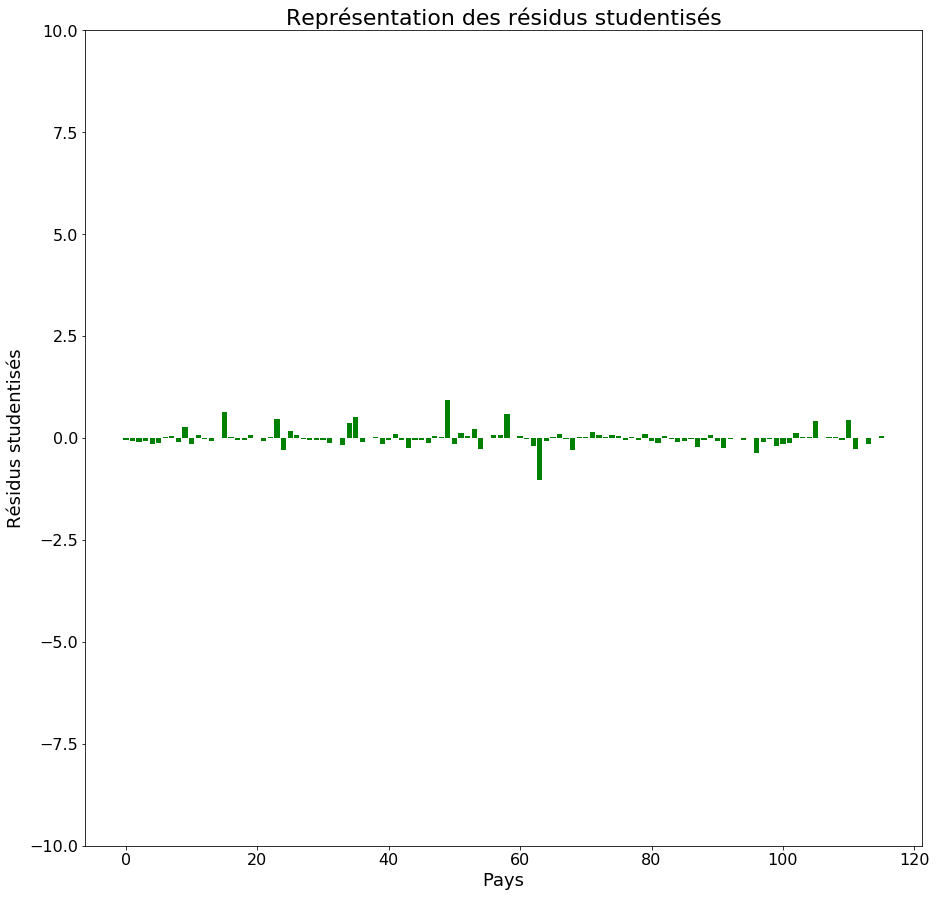

In [162]:
data3 = data.groupby(['country', 'gdpppp', 'gini', 'IGEincome', 'ln_gdpppp']).mean()
data3.reset_index(inplace=True)


# Représentation des leviers
plt.figure(figsize=(15,15))

# Individus entre le seuil mini et le seuil maxi
plt.bar(data3.loc[(data3['rstudent'] <= seuil_rstudent) & (data3['rstudent'] >= -seuil_rstudent)].index,
        data3.loc[(data3['rstudent'] <= seuil_rstudent) & (data3['rstudent'] >= -seuil_rstudent)]['rstudent'], color='g')

# Individus au dessus du seuil maxi
plt.bar(data3.loc[data3['rstudent'] > seuil_rstudent].index,
        data3.loc[data3['rstudent'] > seuil_rstudent]['rstudent'], color='r')

# Individus au dessous du seuil maxi
plt.bar(data3.loc[data3['rstudent'] < -seuil_rstudent].index,
        data3.loc[data3['rstudent'] < -seuil_rstudent]['rstudent'], color='r')


# Décoration et annotations
plt.title('Représentation des résidus studentisés', fontsize=22)
plt.xlabel('Pays', fontsize=18)
plt.xticks(fontsize=16)
plt.ylim(-10,10)
plt.ylabel('Résidus studentisés', fontsize=18)
plt.yticks(fontsize=16)


In [163]:
# Nombre de valeurs atypiques sur les variables à expliquer
res_stu_ln = data3.loc[(data3['rstudent'] > seuil_rstudent) |
                             (data3['rstudent'] < -seuil_rstudent)]

len(res_stu_ln)

0

## Distances de Cook : influence de observations

In [138]:
data['d_cooks'] = reg_multi3.get_influence().cooks_distance[0]
data

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent,levier,rstudent,d_cooks
0,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534,2.120436e-07,-0.271263,3.900734e-09
1,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534,2.120436e-07,-0.271263,3.900734e-09
2,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534,2.120436e-07,-0.271263,3.900734e-09
3,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534,2.120436e-07,-0.271263,3.900734e-09
4,ALB,2008,1,728.89795,7297.0,Albanie,30.462429,0.815874,1,728.89795,6.591534,8.895219,6.591534,2.120436e-07,-0.271263,3.900734e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11599995,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444,1.161266e-05,7.732932,1.736061e-04
11599996,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444,1.161266e-05,7.732932,1.736061e-04
11599997,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444,1.161266e-05,7.732932,1.736061e-04
11599998,ZAF,2008,100,82408.55000,9602.0,Afrique du Sud,66.977850,0.677000,100,82408.55000,11.319444,9.169727,11.319444,1.161266e-05,7.732932,1.736061e-04


In [148]:
# Seuil d'influence selon Cook
seuil_dcook = 4/(n-p)

# Préparation des données
data4 = data.groupby(['country', 'gdpppp', 'gini', 'IGEincome', 'ln_gdpppp']).mean()
data4.reset_index(inplace=True)
data4


,country,gdpppp,gini,IGEincome,ln_gdpppp,year_survey,c_child,y_child,c_parent,y_parent,ln_y_child,ln_y_parent,levier,rstudent,d_cooks
0,ALB,7297.0,30.462429,0.815874,8.895219,2008.0,50.5,2994.829902,50.5,2994.829902,7.851714,7.851714,2.072769e-07,-0.044273,4.716734e-09
1,ARG,13220.0,44.990165,0.500000,9.489486,2008.0,50.5,5847.884654,50.5,5847.884654,8.302053,8.302053,2.167076e-07,-0.072908,5.886285e-08
2,ARM,5611.0,26.310763,0.400000,8.632484,2008.0,50.5,1628.382785,50.5,1628.382785,7.281950,7.281950,3.432760e-07,-0.091622,2.075636e-09
3,AUT,36193.0,27.827911,0.245267,10.496621,2008.0,50.5,16637.600204,50.5,16637.600204,9.589967,9.589967,5.472142e-07,-0.078882,3.728114e-07
4,AZE,8101.0,31.232118,0.500000,8.999743,2008.0,50.5,2357.429023,50.5,2357.429023,7.603900,7.603900,1.825629e-07,-0.148636,3.346155e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,VEN,11756.0,43.402135,0.500000,9.372119,2006.0,50.5,3167.147724,50.5,3167.147724,7.725415,7.725415,1.534332e-07,-0.267347,1.247605e-08
112,VNM,2578.0,37.748096,0.480000,7.854769,2006.0,50.5,1377.773966,50.5,1377.773966,6.993344,6.993344,1.478340e-07,0.010199,1.164584e-09
113,XKX,7544.0,31.447461,0.400000,8.928508,2008.0,50.5,2176.269035,50.5,2176.269035,7.522857,7.522857,1.822367e-07,-0.140070,2.620623e-09
114,YEM,2224.0,37.416124,0.500000,7.707063,2008.0,50.5,1042.635870,50.5,1042.635870,6.715686,6.715686,1.540080e-07,-0.005549,9.095797e-10


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text xticklabel objects>)

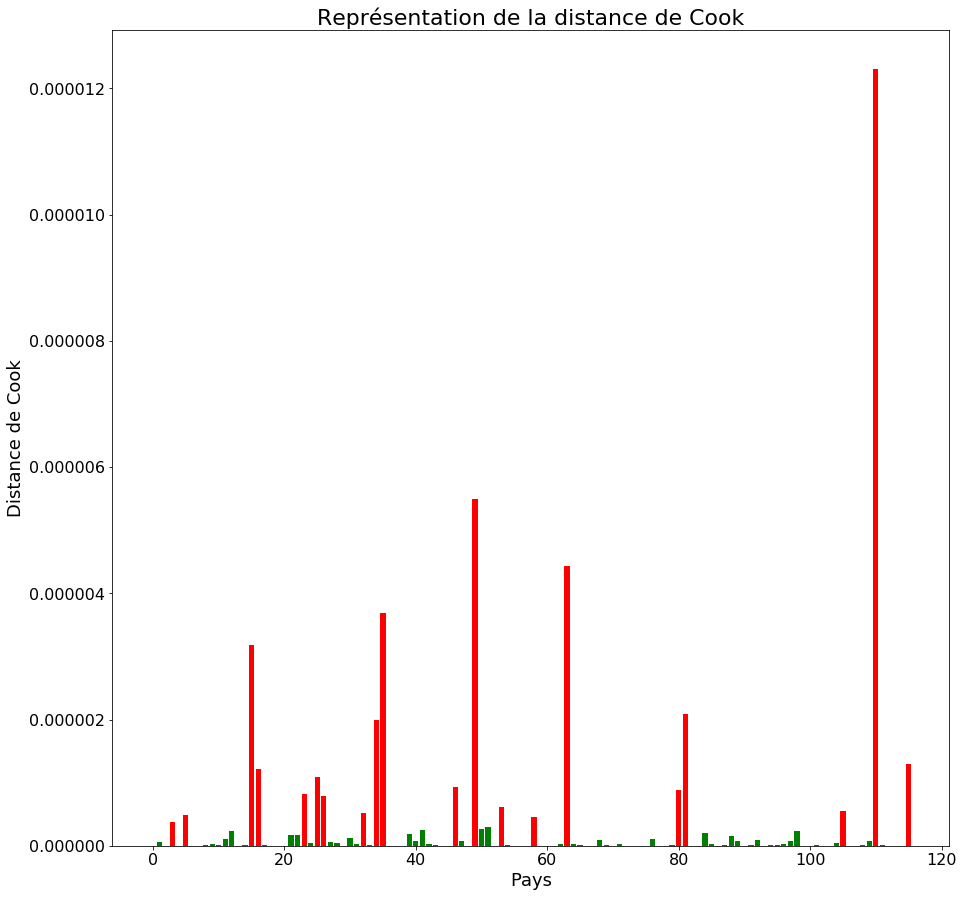

In [154]:
# Représentation de la distances de Cooks
plt.figure(figsize=(15,15))

# Individus sous le seuil
plt.bar(data4.loc[data4['d_cooks'] <= seuil_dcook].index,
        data4.loc[data4['d_cooks'] <= seuil_dcook]['d_cooks'],
       color='g')

# Individus au dessus le seuil
plt.bar(data4.loc[data4['d_cooks'] > seuil_dcook].index,
        data4.loc[data4['d_cooks'] > seuil_dcook]['d_cooks'],
       color='r')

# Décoration et annotations
plt.title('Représentation de la distance de Cook', fontsize=22)
plt.ylabel('Distance de Cook', fontsize=18)
plt.xlabel('Pays', fontsize=18)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)


In [170]:
# Obeservations atypiques et influentes
ind_aty_infl_ln = data.loc[((data['d_cooks'] > seuil_dcook) & (data['rstudent'] > seuil_rstudent) & (data['levier'] > seuil_levier)) 
                                |
                             ((data['d_cooks'] > seuil_dcook) & (data['rstudent'] < -seuil_rstudent) & (data['levier'] > seuil_levier))]
print('Nombre d observations influentes et atypiques :', len(ind_aty_infl_ln))

Nombre d observations influentes et atypiques : 200534


In [167]:
# Pays contenants les observations influentes et atypiques
susp_pt = data.loc[data.index.isin(ind_aty_infl_ln.index)]
susp_pt.reset_index(inplace=True)
susp_pt.groupby('country').count()

,index,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent,levier,rstudent,d_cooks
country,,,,,,,,,,,,,,,,
ARG,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376
AUT,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380,3380
BEL,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933
BGR,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
BIH,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337
BOL,740,740,740,740,740,740,740,740,740,740,740,740,740,740,740,740
BRA,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327,1327
CAN,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655,13655
CHL,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295,2295


In [169]:
len(susp_pt.groupby('country').count())

57

## Detection des problèmes de colinéarité

In [172]:
# Facteur d'influence de la variance (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables_ln2 = reg_multi3.model.exog
[variance_inflation_factor(variables_ln2, i) for i in np.arange(1,variables_ln2.shape[1])]

[2.01263202065129, 1.1864314793279298, 1.810675487426441]

Une variable pose problème dès lors que VIF > 4, ce n'est pas notre cas ici. Pas de problème de colinéarité

## <font color="#0000a0">5. Décomposition de la variance</font>

### Modèle 1 : ln_y_child = A * ln_gdpppp + B * gini

In [53]:
anova_model1 = sm.stats.anova_lm(reg_multi_log2, typ=1)
anova_model1

,df,sum_sq,mean_sq,F,PR(>F)
ln_gdpppp,1.0,1.424120e+07,1.424120e+07,2.146381e+07,0.0
gini,1.0,1.872569e+05,1.872569e+05,2.822268e+05,0.0
Residual,11599997.0,7.696577e+06,6.634982e-01,NaN,NaN


In [54]:
variance_ln_gdpppp_m1 = round(anova_model1.sum_sq['ln_gdpppp'] *100 / anova_model1.sum_sq.sum(),2)
variance_gini_m1 = round(anova_model1.sum_sq['gini'] *100 / anova_model1.sum_sq.sum(),2)

print("La variable ln_gdpppp explique {} du modèle 1".format(variance_ln_gdpppp_m1))
print("La variable gini explique {} du modèle 1".format(variance_gini_m1))


La variable ln_gdpppp explique 64.37 du modèle 1
La variable gini explique 0.85 du modèle 1


### Modèle 2 : ln_y_child = A * ln_gdpppp + B * gini + C * ln_y_parent

In [55]:
anova_model2 = sm.stats.anova_lm(reg_multi4, typ=1)
anova_model2

,df,sum_sq,mean_sq,F,PR(>F)
ln_gdpppp,1.0,1.424120e+07,1.424120e+07,3.205548e+07,0.0
gini,1.0,1.872569e+05,1.872569e+05,4.214961e+05,0.0
ln_y_parent,1.0,2.543078e+06,2.543078e+06,5.724207e+06,0.0
Residual,11599996.0,5.153499e+06,4.442673e-01,NaN,NaN


In [56]:
variance_ln_gdpppp_m2 = round(anova_model2.sum_sq['ln_gdpppp'] *100 / anova_model2.sum_sq.sum(),2)
variance_gini_m2 = round(anova_model2.sum_sq['gini'] *100 / anova_model2.sum_sq.sum(),2)
variance_ln_y_parent_m2 = round(anova_model2.sum_sq['ln_y_parent'] *100 / anova_model2.sum_sq.sum(),2)


print("La variable ln_gdpppp explique {} du modèle 2".format(variance_ln_gdpppp_m2))
print("La variable gini explique {} du modèle 2".format(variance_gini_m2))
print("La variable ln_y_parent explique {} du modèle 2".format(variance_ln_y_parent_m2))

La variable ln_gdpppp explique 64.37 du modèle 2
La variable gini explique 0.85 du modèle 2
La variable ln_y_parent explique 11.49 du modèle 2


## <font color="#0000a0">6. Conclusion</font>

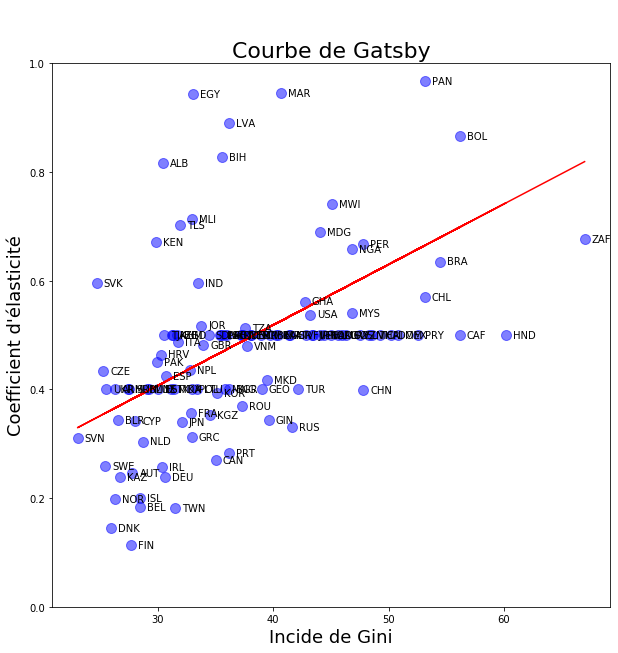

In [115]:
# Data
y = dgat['IGEincome']
x = dgat['gini']
labels = dgat['country']

# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10, 10))


# Plot the scatter points
ax.scatter(x, y,
           color="blue",  # Color of the dots
           s=100,         # Size of the dots
           alpha=0.5,     # Alpha of the dots
           linewidths=1)  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
    
# Calcul du coefficient de corrélation
pear = scipy.stats.pearsonr(x,y)[0]

# Cacul des paramètres
slope, intercept, _, __, ___ = scipy.stats.linregress(x, y)

# Droite de régression
fitLine = slope * x + intercept
plt.plot(x, fitLine, c='r')
plt.title('Courbe de Gatsby', fontsize=22)
plt.ylabel('Coefficient d\'élasticité', fontsize=18)
plt.ylim(0, 1)
plt.xlabel('Incide de Gini', fontsize=18)
#plt.text(0.45, 0.1, f'Coefficient de corrélation: {pear:.2}', color='r', fontsize=18)



# Show the plot
plt.show()

#### Plus les indices de Gini sont élevés (pays inégalitaires), plus le coefficient d'elasticité est fort (mobilité intergénérationnelle faible), donc il y a forte influence de la situation familiale sur le revenu des enfants. Des revenus faibles parents entrainent des revenus faibles chez l'enfant.

#### Plus un coefficient de gini est faible (pays égalitaire), plus le coefficient d'élasticité est faible donc la mobilité intergénérationnelle est forte, les enfants ont moins d'influence de leur famille et donc davantage de chances de posséder un haut revenu.

In [114]:
data_dd.sort_values('gdpppp', ascending = False)

,country,year_survey,c_child,y_child,gdpppp,country_name,gini,IGEincome,c_parent,y_parent,ln_y_child,ln_gdpppp,ln_y_parent
6322639,LUX,2008,55,23137.01200,73127.00000,Luxembourg,29.293516,0.4,23,15040.82500,10.049189,11.199953,9.618523
6357018,LUX,2008,4,8312.03100,73127.00000,Luxembourg,29.293516,0.4,58,23886.05300,9.025459,11.199953,10.081050
6357034,LUX,2008,6,9524.44000,73127.00000,Luxembourg,29.293516,0.4,58,23886.05300,9.161616,11.199953,10.081050
6357042,LUX,2008,7,10047.25700,73127.00000,Luxembourg,29.293516,0.4,58,23886.05300,9.215055,11.199953,10.081050
6357051,LUX,2008,8,10340.48300,73127.00000,Luxembourg,29.293516,0.4,58,23886.05300,9.243822,11.199953,10.081050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067544,COD,2008,64,243.53053,303.19305,"Congo, République démocratique du",44.399690,0.5,68,267.24573,5.495242,5.714370,5.588169
2067535,COD,2008,63,238.96000,303.19305,"Congo, République démocratique du",44.399690,0.5,68,267.24573,5.476296,5.714370,5.588169
2067522,COD,2008,62,234.03426,303.19305,"Congo, République démocratique du",44.399690,0.5,68,267.24573,5.455468,5.714370,5.588169
2067515,COD,2008,61,229.45421,303.19305,"Congo, République démocratique du",44.399690,0.5,68,267.24573,5.435703,5.714370,5.588169
